In [1]:
import scipy.io
import numpy as np
import operator as op

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt # matplotlib
matplotlib.rcParams['figure.figsize'] = list(map(lambda x: 2*x, matplotlib.rcParams['figure.figsize']))
matplotlib.style.use('ggplot')

In [3]:
#data = scipy.io.loadmat('../../data2.mat')
data = scipy.io.loadmat('../../data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'bin', 'data1_Xian', 'label1', 'spotColumn1_Xian', 'spotRow1_Xian'])

In [4]:
mz_values = data['bin'].T

In [5]:
#coorX = data['spotRow2_Xian'][0]
coorX = data['spotRow1_Xian'][0]
coorX

array([136, 135, 137, ...,  90,  92,  91], dtype=uint8)

In [6]:
#coorY = data['spotColumn2_Xian'][0]
coorY = data['spotColumn1_Xian'][0]
coorY

array([166, 166, 166, ..., 125, 125, 125], dtype=uint8)

In [7]:
coorX -= coorX.min()
coorY -= coorY.min()

nrows = coorX.max() + 1
ncols = coorY.max() + 1
print('nrows %d, ncols %d' % (nrows, ncols))

nrows 129, ncols 154


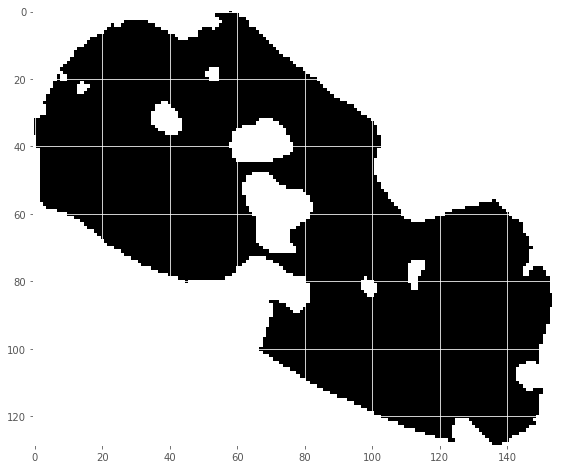

In [8]:
mask = np.zeros((nrows, ncols))
for r, c in zip(coorX, coorY):
    mask[r,c] = 1

plt.imshow(mask, cmap='binary')

In [9]:
data_cube = np.zeros((nrows, ncols, mz_values.shape[0]))
data_cube[coorX, coorY, :] = data["data1_Xian"]

data_matrix = data['data1_Xian']
data_matrix.shape

(9577, 14000)

In [10]:
row2grid = {r: (coorX[r], coorY[r]) for r in range(data_matrix.shape[0])}
grid2row = {(coorX[r], coorY[r]): r for r in range(data_matrix.shape[0])}

get_bin = lambda mz: np.argmin(np.abs(mz_values - mz))

real_rows = []
real_rows_xy = []
for r in range(nrows):
    for c in range(ncols):
        try:
            row = grid2row[(r, c)]
            real_rows_xy.append((r, c))
            real_rows.append(row)
        except:
            pass
        
real_rows = np.array(real_rows)
real_rows.shape

real_rows_xy = np.array(np.array(real_rows_xy))
real_rows_xy.shape

(9577, 2)

In [11]:
def make_image(rows): # very inefficient implementation but doesnt matter
    """Makes a 2d image from row indices in raw data."""
    img = np.zeros((nrows, ncols))    
    for r in range(nrows):
        for c in range(ncols):
            try:
                row = grid2row[(r, c)]
                img[r, c] = rows[row]
            except:
                pass
    return img

def make_image_real(rows):
    """Makes a 2d image from real rows with data (i.e., rows in real_rows)."""
    img = np.zeros((nrows, ncols)) 
    for idx, val in enumerate(rows):
        x, y = real_rows_xy[idx]
        img[x, y] = val
    return img

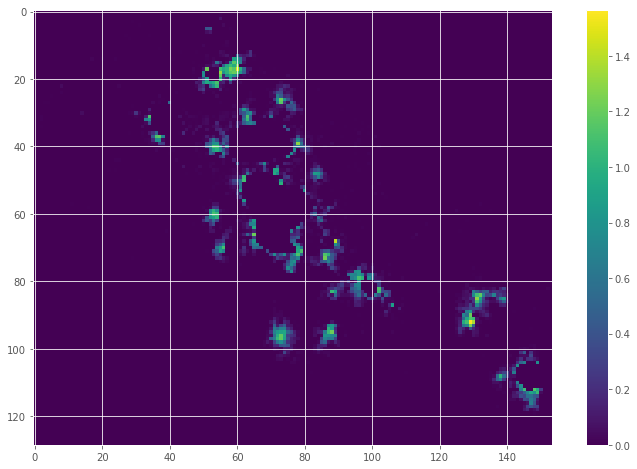

In [12]:
insulin_bin_idx = get_bin(5800) # human insulin protein has molecular mass 5808 Da
#plt.imshow(data_cube[:,:, insulin_bin_idx])

insulin_img = make_image(data_matrix[:, insulin_bin_idx]) 
plt.imshow(np.log10(1+insulin_img), cmap='viridis') # log10 changes the distribution so we can see what's going on better
plt.colorbar()
#python 3

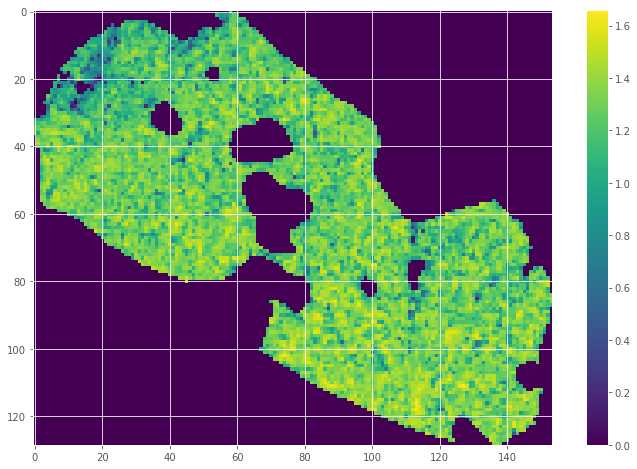

In [39]:
labels = data['label1']
#print('%d labels, %d real data points, %d positives' % (len(labels), len(labels[real_rows]), sum(labels)))
#plt.imshow(make_image(labels))
#plt.colorbar()

insulin_img = make_image(labels)
plt.imshow(np.log10(1+insulin_img), cmap='viridis') # log10 changes the distribution so we can see what's going on better
plt.colorbar()

(array([   3.,    6.,    2.,    3.,    1.,    4.,    3.,    4.,    0.,
           4.,    7.,    4.,   13.,    5.,    6.,    9.,   11.,   14.,
          19.,   17.,   28.,   28.,   37.,   32.,   72.,   67.,   78.,
          90.,  124.,  152.,  183.,  219.,  291.,  341.,  432.,  545.,
         661.,  680.,  803.,  869.,  922.,  804.,  741.,  524.,  339.,
         194.,  111.,   56.,   14.,    5.]),
 array([ 0.        ,  0.03319106,  0.06638212,  0.09957318,  0.13276424,
         0.1659553 ,  0.19914636,  0.23233742,  0.26552848,  0.29871954,
         0.3319106 ,  0.36510166,  0.39829272,  0.43148378,  0.46467484,
         0.49786589,  0.53105695,  0.56424801,  0.59743907,  0.63063013,
         0.66382119,  0.69701225,  0.73020331,  0.76339437,  0.79658543,
         0.82977649,  0.86296755,  0.89615861,  0.92934967,  0.96254073,
         0.99573179,  1.02892285,  1.06211391,  1.09530497,  1.12849603,
         1.16168709,  1.19487815,  1.22806921,  1.26126027,  1.29445133,
         1.32764

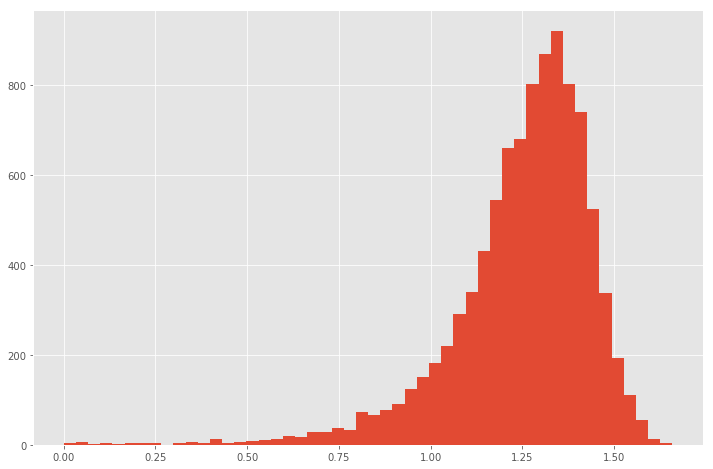

In [40]:
#plt.hist(labels, bins=50)
plt.hist(np.log10(1+labels), bins=50)

9577 labels, 9577 real data points, 668 positives


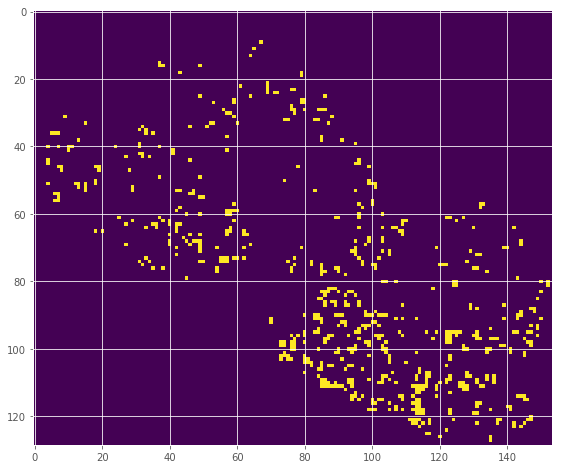

In [41]:
cutoff =10 ** 1.45

labels = labels > cutoff
print('%d labels, %d real data points, %d positives' % (len(labels), len(labels[real_rows]), sum(labels)))
#plt.imshow(make_image(labels))

plt.imshow(make_image_real(labels[real_rows]))

In [42]:
real_labels = labels[real_rows]
real_data = data_matrix[real_rows, :]
real_data = real_data[:, np.arange(data_matrix.shape[1]) != insulin_bin_idx]
real_data.shape

(9577, 13999)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import preprocessing

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [45]:
data_pp = SelectKBest(chi2, k=100).fit_transform(real_data, real_labels)

In [46]:
minvals = np.amin(data_pp, 0)
maxvals = np.amax(data_pp, 0)
ranges = 1.0 / (maxvals - minvals)
scaler = np.diag(ranges)

data_pp_scaled = np.dot(data_pp, scaler)
data_pp_scaled.shape

(9577, 100)

In [47]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
import optunity
import optunity.metrics
import optunity.cross_validation

In [48]:
# extend data matrix to include spatial location of pixels in first 2 cols
data = np.hstack((real_rows_xy, data_pp_scaled))

@optunity.cross_validated(x=data, y=real_labels, num_folds=2,
                         aggregator=optunity.cross_validation.identity)
def nested_cv(x_train, y_train, x_test, y_test):

    # extract spatial location of pixels (first 2 cols)
    x_train = x_train[:, 2:]
    rows = x_test[:, 0]
    cols = x_test[:, 1]
    x_test = x_test[:, 2:]
    
    # inner cross-validation to estimate performance of a set of hyperparameters
    @optunity.cross_validated(x=x_train, y=y_train, num_folds=3, num_iter=2)
    def inner_cv(x_train, y_train, x_test, y_test, C):
        model = LinearSVC(C=C).fit(x_train, y_train)
        predictions = model.decision_function(x_test)
        roc = optunity.metrics.roc_auc(y_test, predictions)
        #print('auroc in xval: %1.3f' % roc)
        return roc

    hpars, info, _ = optunity.maximize(inner_cv, num_evals=10, C=[0, 10], pmap=optunity.parallel.pmap)
    print('')
    print('Hyperparameters: ' + str(hpars))
    print('Cross-validated AUROC after tuning: %1.3f' % info.optimum)
    model = LinearSVC(**hpars).fit(x_train, y_train)
    predictions = model.decision_function(x_test)
    auc = optunity.metrics.roc_auc(y_test, predictions)    
    return (auc, np.vstack((rows, cols, predictions)))

In [49]:
res = nested_cv()
mean_roc_auc = sum(map(op.itemgetter(0), res)) / len(res)
print('')
print('Mean area under ROC curve in outer cross-validation: %1.3f' % mean_roc_auc)

/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning


Hyperparameters: {'C': 8.583984375}
Cross-validated AUROC after tuning: 0.997


/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Hyperparameters: {'C': 9.6044921875}
Cross-validated AUROC after tuning: 0.997

Mean area under ROC curve in outer cross-validation: 0.998


In [50]:
predictions = np.hstack(map(op.itemgetter(1), res))
prediction_matrix = np.zeros((nrows, ncols))
for i in range(predictions.shape[1]):
    row = predictions[0, i]
    col = predictions[1, i]
    val = predictions[2, i]
    prediction_matrix[row, col] = val

/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/esat/bioidata/guests/wzhang/wanqiu/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


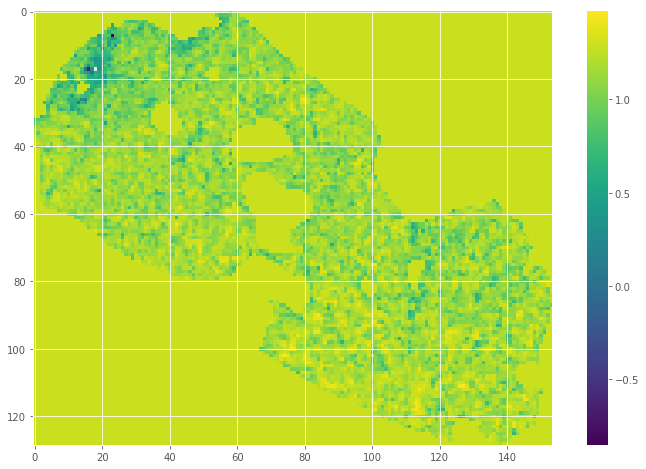

In [51]:
plt.imshow(np.log10(prediction_matrix - prediction_matrix[:].min()))
#plt.imshow(prediction_matrix)
#plt.imshow(prediction_matrix > 0) # default svm treshold
plt.colorbar()